# 1. 라이브러리 로드

In [1]:
! pip install keras-hypetune # 케라스 그리드 서치
! pip install fitter # GEV 분포 생성

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 966.0/966.0 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: hyperopt
    Found existing installation: hyperopt 0.2.7
    Uninstalling hyperopt-0.2.7:
      Successfully uninstalled hyperopt-0.2.7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 75.5 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [2]:
import os
import random
import warnings
import numpy as np
from scipy import stats
from fitter import Fitter
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from kerashypetune import KerasGridSearch

# 2. 데이터 로드

In [3]:
## Read data
filepath = 'https://github.com/mchoimis/tsdl/raw/main/crime/crime.csv'
df = pd.read_csv(filepath)
df['Date'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])

df = pd.DataFrame({'n_crimes':df.Date.value_counts().sort_index()})
df['month'] = df.index.month
df['wday'] = df.index.dayofweek
df['day'] = df.index.day

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5308 entries, 2003-01-01 to 2017-07-13
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   n_crimes  5308 non-null   int64
 1   month     5308 non-null   int32
 2   wday      5308 non-null   int32
 3   day       5308 non-null   int32
dtypes: int32(3), int64(1)
memory usage: 145.1 KB


In [4]:
df.tail()

,n_crimes,month,wday,day
Date,,,,
2017-07-09,119,7,6,9
2017-07-10,100,7,0,10
2017-07-11,104,7,1,11
2017-07-12,96,7,2,12
2017-07-13,51,7,3,13


In [5]:
df.head()

,n_crimes,month,wday,day
Date,,,,
2003-01-01,191,1,2,1
2003-01-02,148,1,3,2
2003-01-03,160,1,4,3
2003-01-04,146,1,5,4
2003-01-05,120,1,6,5


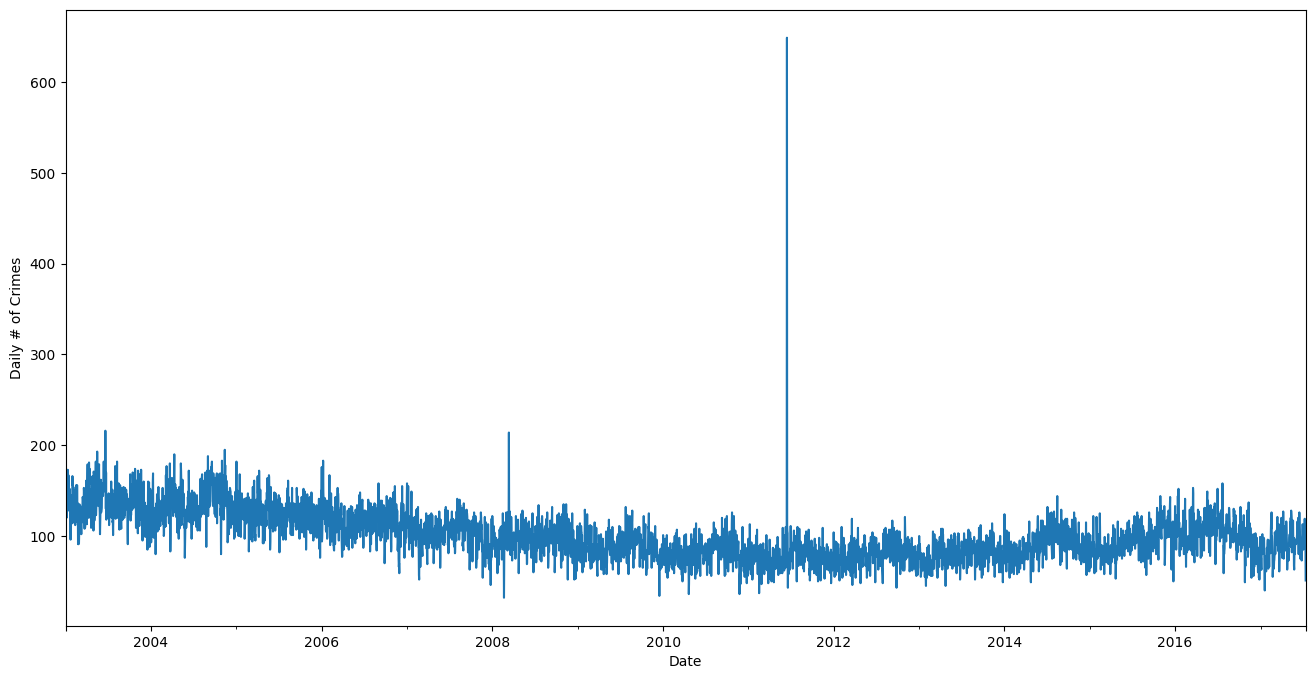

In [6]:
## Plot aggregated daily crimes
df.n_crimes.plot(figsize=(16,8))
plt.ylabel('Daily # of Crimes')

plt.show()

In [7]:
'''
  - 2011년 6월 15일 벤쿠버 하키 폭동: https://www.vanchosun.com/news/main/frame.php?main=1&boardId=18&bdId=77901&cpage1=1
'''
df.sort_values('n_crimes', ascending=False).head()

,n_crimes,month,wday,day
Date,,,,
2011-06-15,649,6,2,15
2003-06-20,216,6,4,20
2008-03-12,214,3,2,12
2004-11-12,195,11,4,12
2003-05-16,193,5,4,16


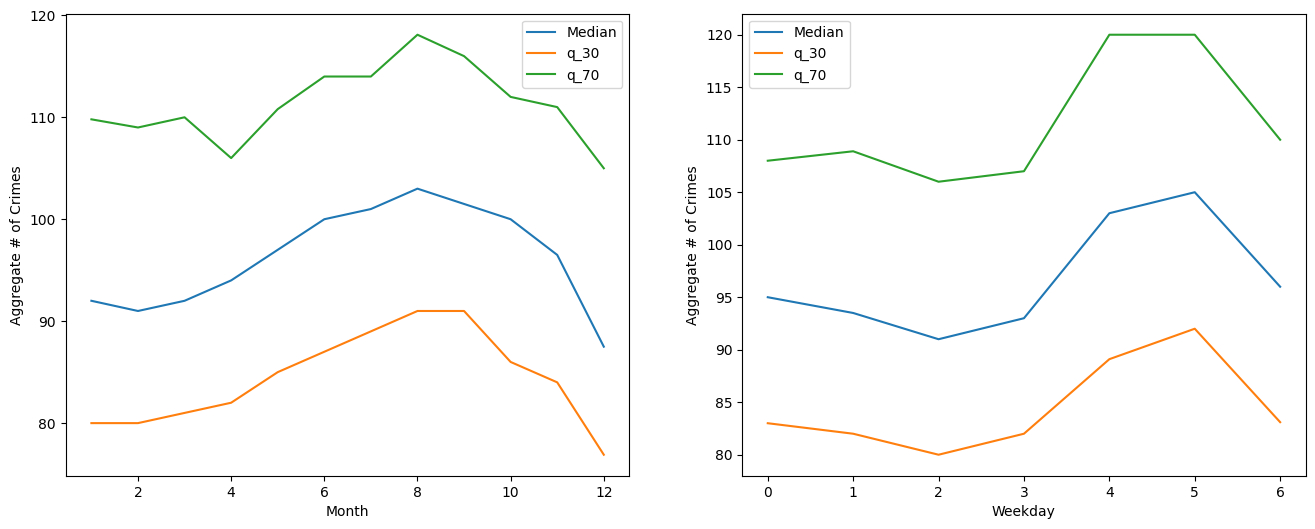

In [8]:
## Plot seasonality
plt.figure(figsize=(16,6))

# 8월에 대체적으로 범죄 많이 일어남
plt.subplot(121)
df.n_crimes.groupby(df.index.month).median().rename('Median').plot(ax=plt.gca(), legend=True)
df.n_crimes.groupby(df.index.month).apply(np.quantile, 0.3).rename('q_30').plot(legend=True)
df.n_crimes.groupby(df.index.month).apply(np.quantile, 0.7).rename('q_70').plot(legend=True)
plt.ylabel('Aggregate # of Crimes'); plt.xlabel('Month')

# 목, 금요일에 대체적으로 많이 발생
plt.subplot(122)
df.n_crimes.groupby(df.index.weekday).median().rename('Median').plot(ax=plt.gca(), legend=True)
df.n_crimes.groupby(df.index.weekday).apply(np.quantile, 0.3).rename('q_30').plot(legend=True)
df.n_crimes.groupby(df.index.weekday).apply(np.quantile, 0.7).rename('q_70').plot(legend=True)
plt.ylabel('Aggregate # of Crimes'); plt.xlabel('Weekday')

plt.show()

# 3. 데이터 전처리

In [9]:
## Define utility functions

def create_windows(data, window_shape, step = 1, start_id = None, end_id = None):
    '''주어진 데이터 배열 슬라이딩 윈도우(sliding window) 방식으로 split

      -Args
        @data: 입력 데이터 배열
        @window_shape: 슬라이딩 윈도우의 크기 또는 길이
        @step: 윈도우 이동 간격
        @start_id: 데이터 배열의 슬라이싱 시작 인덱스. 기본값은 None이며, 이 경우 데이터의 처음부터 시작
        @end_id: 데이터 배열의 슬라이싱 끝 인덱스. 기본값은 None이며, 이 경우 데이터의 끝까지 사용
    '''

    # 1. 데이터 배열 변환 & 1차원 배열은 2차원으로 변환
    data = np.asarray(data)
    data = data.reshape(-1,1) if np.prod(data.shape) == max(data.shape) else data

    # 2. 시작 및 끝 인덱스 설정
    start_id = 0 if start_id is None else start_id
    end_id = data.shape[0] if end_id is None else end_id

    # 3. 데이터 슬라이싱
    data = data[int(start_id):int(end_id), :]

    # 4. 윈도우 및 스텝 크기 설정
    window_shape = (int(window_shape), data.shape[-1])
    step = (int(step),) * data.ndim # 설정한 step 크기 * 데이터 차원 수

    # 5. 슬라이싱 인덱스와 스트라이드 설정
    slices = tuple(slice(None, None, st) for st in step)
    indexing_strides = data[slices].strides

    # 6. 윈도우 인덱스 형태 계산 -> 각 차원에서 윈도우 이동 횟수 계산
    win_indices_shape = ((np.array(data.shape) - window_shape) // step) + 1

    # 7. 윈도우 데이터를 새로운 형태와 스트라이드로 변환
    new_shape = tuple(list(win_indices_shape) + list(window_shape))
    strides = tuple(list(indexing_strides) + list(data.strides))

    # 8. 슬라이싱 윈도우 데이터 변환
    window_data = np.lib.stride_tricks.as_strided(data, shape=new_shape, strides=strides)

    return np.squeeze(window_data, 1)


# 배열 정규화 및 역정규화 수행
class Scaler3D:

    def fit(self, X):
        self.mean = X.reshape(-1, X.shape[-1]).mean(0).reshape(1, 1, -1)
        self.std = X.reshape(-1, X.shape[-1]).std(0).reshape(1, 1, -1)
        return self

    def transform(self, X):
        return (X - self.mean) / self.std

    def inverse_transform(self, X):
        return (X * self.std) + self.mean


def prepare_seq(num_X, cat1_X, cat2_X, scaler=None):
    '''여러 입력 데이터를 하나의 사전(dictionary)으로 준비

      -Args
        @num_X: 수치형 데이터 (3차원 배열 형태, 예: (samples, timesteps, features))
        @cat1_X: 범주형 데이터 세트 1 (3차원 배열 형태, 예: (samples, timesteps, num_categories))
        @cat2_X: 범주형 데이터 세트 2 (3차원 배열 형태, 예: (samples, timesteps, num_categories))
        @scaler: 선택적 매개변수, 데이터 표준화를 위한 스케일러 객체 (기본값은 None)
    '''

    if scaler is not None:
        num_X = scaler.transform(num_X)

    # 1. 정규화된 수치 데이터 추가
    inp_dict = {}
    inp_dict['inp_num'] = num_X

    # 2. 범주형 데이터 처리
    for i,c in enumerate(cat_var): # ['month','wday','day']
        inp_dict[f"inp_{c}_cat1"] = cat1_X[:,:,i]
        inp_dict[f"inp_{c}_cat2"] = cat2_X[:,:,i]

    return inp_dict

In [11]:
time_h = 7 # 예측 일수
window_shape = 21 # 슬라이딩 윈도우 크기

target = ['n_crimes'] # 종속변수 (범죄량)
cat_var = ['month','wday','day'] # (범주형 변수)

# 훈련, 검증 세트 인덱스
_id_train, _id_valid = train_test_split(np.arange((len(df) - window_shape - time_h + 1)), test_size=0.3, shuffle=False)

# 입력, 타겟 데이터 슬라이딩 윈도우 변환
_num_X = create_windows(df[target], window_shape=window_shape, end_id=-time_h)
_cat1_X = create_windows(df[cat_var], window_shape=window_shape, end_id=-time_h)
_cat2_X = create_windows(df[cat_var], window_shape=time_h, start_id=window_shape)
_target = create_windows(df[target], window_shape=time_h, start_id=window_shape)

# 훈련, 검증데이터 분할
_num_X_train = _num_X[_id_train]; _num_X_valid = _num_X[_id_valid]
_cat1_X_train = _cat1_X[_id_train]; _cat1_X_valid = _cat1_X[_id_valid]
_cat2_X_train = _cat2_X[_id_train]; _cat2_X_valid = _cat2_X[_id_valid]
_target_train = _target[_id_train]; _target_valid = _target[_id_valid]

# 수치데이터 정규화
X_scaler = Scaler3D().fit(_num_X_train)
y_scaler = Scaler3D().fit(_target_train)

# 훈련데이터 독립 및 종속 변수 데이터 구성
X_train = prepare_seq(_num_X_train, _cat1_X_train, _cat2_X_train, scaler=X_scaler)
y_train = y_scaler.transform(_target_train)

# 검증데이터 독립 및 종속 변수 데이터 구성
X_valid = prepare_seq(_num_X_valid, _cat1_X_valid, _cat2_X_valid, scaler=X_scaler)
y_valid = y_scaler.transform(_target_valid)

# 4. 모델링

In [19]:
### Define Model

def set_seed(seed):

    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model(param):

    set_seed(33)

    # 1. input layer 생성
    inp_num = Input((window_shape,1), name='inp_num')

    # 2. 범주형 변수 embedding layer 생성
    embeddings = {
        'month': Embedding(12+1, param['emb_dim']),
        'wday': Embedding(6+1, param['emb_dim']),
        'day': Embedding(31+1, param['emb_dim'])
    }

    # 3. 과거 범주형 입력 처리
    # input & embedding layer 연결
    inp_cat1, emb_cat = [], []
    for c in cat_var: # ['month','wday','day']
        _inp_c1 = Input((window_shape,), name=f"inp_{c}_cat1")
        emb = embeddings[c](_inp_c1)
        inp_cat1.append(_inp_c1)
        emb_cat.append(emb)

    # 4. 수치형 & 과거 범주형 입력 결합
    enc = Concatenate()([inp_num] + emb_cat)

    # 5. 결합된 입력 LSTM 에 전달하여 인코더 구성
    enc = LSTM(param['lstm_unit'], return_sequences=False)(enc)

    # 6. 미래 범주형 입력 처리
    inp_cat2, emb_future = [], []
    for c in cat_var:
        _inp_c2 = Input((time_h,), name=f"inp_{c}_cat2")
        emb = embeddings[c](_inp_c2)
        inp_cat2.append(_inp_c2)
        emb_future.append(emb)

    # 7. 디코더 구성
    # RepeatVector는 인코더의 출력을 디코더의 입력 시퀀스 길이에 맞춰 반복 => 디코더가 예측할 각 타임 스텝마다 인코더의 전체 정보 사용할 수 있도록 함
    x = RepeatVector(time_h)(enc)
    dec = Concatenate()([x] + emb_future)
    dec = LSTM(param['lstm_unit'], return_sequences=True)(dec) # return_sequences=True를 통해 디코더가 각 타임 스텝의 출력 반환하도록 함

    # 8. output layer 생성
    # 입력 시퀀스의 각 타임 스텝에 동일한 레이어 독립 적용
    output = TimeDistributed(Dense(1))(dec) # (batch_size, timesteps, 1)

    # 9. input + output layer => 모델 생성
    model = Model([inp_num] + inp_cat1 + inp_cat2, output)

    # 10. 모델 컴파일
    model.compile(Adam(lr=param['lr']), 'mse')

    return model

In [20]:
## Modeling Fitting
param_grid = {
    'lstm_unit': [128,64,32],
    'emb_dim': [8,16,32],
    'lr': [1e-4,1e-3], ## learning rate
    'epochs': 100,
    'batch_size': 64
}

es = EarlyStopping(patience=7, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = get_model
kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[es])


18 trials detected for ('lstm_unit', 'emb_dim', 'lr', 'epochs', 'batch_size')



***** (1/18) *****
Search({'lstm_unit': 128, 'emb_dim': 8, 'lr': 0.0001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22043 at epoch 3



***** (2/18) *****
Search({'lstm_unit': 128, 'emb_dim': 8, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22043 at epoch 3



***** (3/18) *****
Search({'lstm_unit': 128, 'emb_dim': 16, 'lr': 0.0001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22035 at epoch 2



***** (4/18) *****
Search({'lstm_unit': 128, 'emb_dim': 16, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22035 at epoch 2



***** (5/18) *****
Search({'lstm_unit': 128, 'emb_dim': 32, 'lr': 0.0001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22026 at epoch 6



***** (6/18) *****
Search({'lstm_unit': 128, 'emb_dim': 32, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22026 at epoch 6



***** (7/18) *****
Search({'lstm_unit': 32, 'emb_dim': 8, 'lr': 0.0001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22023 at epoch 4



***** (8/18) *****
Search({'lstm_unit': 32, 'emb_dim': 8, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22023 at epoch 4



***** (9/18) *****
Search({'lstm_unit': 32, 'emb_dim': 16, 'lr': 0.0001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.2214 at epoch 10



***** (10/18) *****
Search({'lstm_unit': 32, 'emb_dim': 16, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.2214 at epoch 10



***** (11/18) *****
Search({'lstm_unit': 32, 'emb_dim': 32, 'lr': 0.0001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22272 at epoch 6



***** (12/18) *****
Search({'lstm_unit': 32, 'emb_dim': 32, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22272 at epoch 6



***** (13/18) *****
Search({'lstm_unit': 64, 'emb_dim': 8, 'lr': 0.0001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.21898 at epoch 3



***** (14/18) *****
Search({'lstm_unit': 64, 'emb_dim': 8, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.21898 at epoch 3



***** (15/18) *****
Search({'lstm_unit': 64, 'emb_dim': 16, 'lr': 0.0001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.21873 at epoch 10



***** (16/18) *****
Search({'lstm_unit': 64, 'emb_dim': 16, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.21873 at epoch 10



***** (17/18) *****
Search({'lstm_unit': 64, 'emb_dim': 32, 'lr': 0.0001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.21979 at epoch 8



***** (18/18) *****
Search({'lstm_unit': 64, 'emb_dim': 32, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.21979 at epoch 8


In [21]:
print('BEST PARAM:', kgs.best_params)

BEST PARAM: {'lstm_unit': 64, 'emb_dim': 16, 'lr': 0.0001, 'epochs': 10, 'batch_size': 64, 'steps_per_epoch': 58}


In [22]:
## Get predicted values
pred = np.squeeze(
    y_scaler.inverse_transform(
        kgs.best_model.predict(X_valid)
    ), -1)

y_valid = np.squeeze(y_scaler.inverse_transform(y_valid), -1)

50/50 [==============================] - 1s 5ms/step


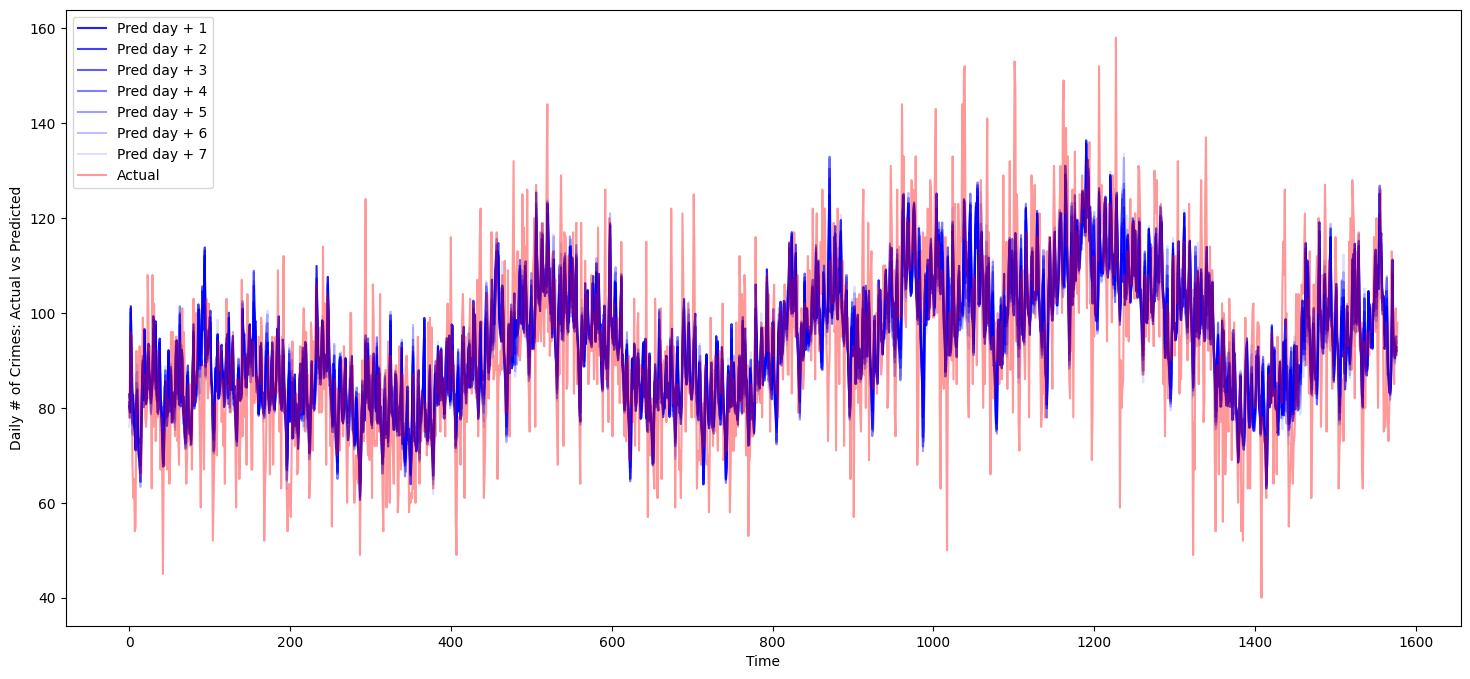

In [23]:
## Visualize Test vs Predicted
## Test vs prediction values are on different time horizons
plt.figure(figsize=(18, 8))

for t_h in range(time_h):
    plt.plot(
        pred[(time_h-t_h):-(t_h+1), t_h],
        c='blue',
        alpha=1-1/(time_h+1)*(t_h+1),
        label=f"Pred day + {t_h+1}"
    )

plt.plot(y_valid[time_h:,0], c='red', alpha=0.4, label='Actual')

plt.ylabel('Daily # of Crimes: Actual vs Predicted')
plt.xlabel('Time')
plt.legend()

plt.show()

In [24]:
## Get model and baseline mse

mse_model = {}
mse_baseline = {}

for t_h in range(time_h):

    _mse = mse(y_valid[1:,t_h], y_valid[:-1,0])
    mse_baseline[f"day + {t_h+1}"] = _mse

    _mse = mse(y_valid[:,t_h], pred[:,t_h])
    mse_model[f"day + {t_h+1}"] = _mse

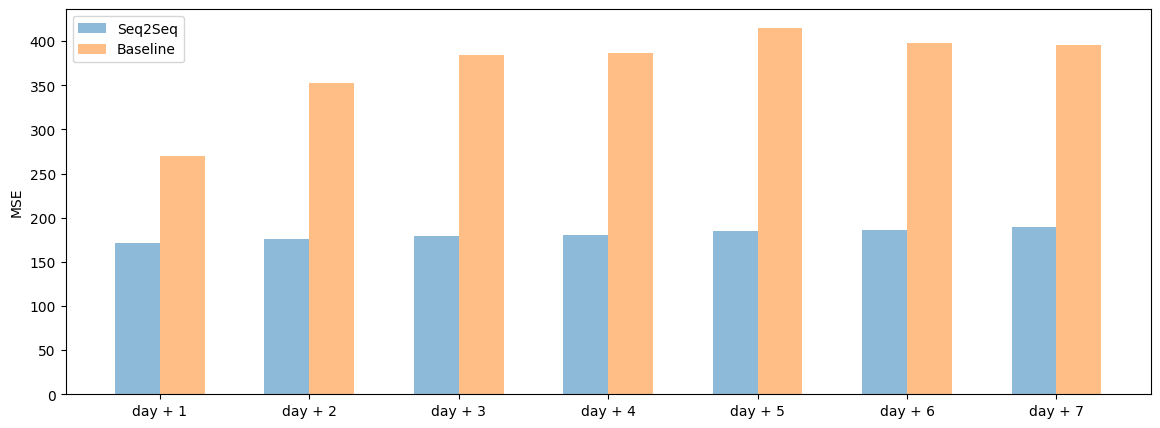

In [25]:
## Plot MSEs
## MSEs are computed on different time horizons
plt.figure(figsize=(14,5))

plt.bar(np.arange(len(mse_model))-0.15, mse_model.values(), alpha=0.5, width=0.3, label='Seq2Seq')
plt.bar(np.arange(len(mse_baseline))+0.15, mse_baseline.values(), alpha=0.5, width=0.3, label='Baseline')

plt.xticks(range(len(mse_baseline)), mse_baseline.keys())
plt.ylabel('MSE')
plt.legend()

plt.show()